In [ ]:
# import
import torch as torch 
from torch import nn 
from torchvision import transforms  #  图像原始处理
from torchvision import datasets   
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
from tqdm import tqdm   #  import to fix during trainning :Error while Multiprocessing in Dataloader
gpu_available = torch.cuda.is_available()

if gpu_available:
    device = "cuda" 
    print("Cuda is available")
else: 
  device = "cpu"
  print("CUDA is not available. Execution time on the cpu is slow.")

import os
from os import path
from torch.utils.tensorboard import SummaryWriter


CUDA is not available. Execution time on the cpu is slow.


In [ ]:
# 生成log文件保存的目录文件夹
path_to_logs = "myLogs"
path_to_models = "myModels"
path_to_data = "data"   #  运行后目录下出现三个对应名字的文件夹

### Set this flat to true if you really want to train from scratch
TRAIN_IN_NOTEBOOK = False 

#Safe directory creation
def mksafe_dir(path):
    if not os.path.isdir(path):
        os.makedirs(path)

#Make directories if not already available
for directory in [path_to_logs, path_to_models, path_to_data]:
    mksafe_dir(directory)

#NOTEs：

After the model built and successed to run， the loss dont decrease during training： my hypothesis to this phenomen is ：
1. LR
2. Optimizer 
3. Model Complexity
4. Batch Size

Further I must tune this hyper Para to see if I can improve its performance
1. After changing LR from 0.01 to 0.005 the model starts to make its loss smaller

In [ ]:

# 注意事项

# ********  ********
# ********   Activation is  ReLU     
# ********   there is no argument such as  reduction='sum' in CrossentropyLoss,... 
# ********   if you add it, the code still run but the loss and accuracy perform badly             
# ********   ... x.view()  method and transform's definition worth a deep look  
# ********  ********




 1. Prepare Data    DataSet ： N x 3 x W x H   :(batch * chanel * width * height)
 2. to Tensor， 定义 transforms ：  transforms raw input W x H x C    ***to*** C x W x H data waiting for process，and switch data to Tensor type

In [ ]:
#TRAIN_IN_NOTEBOOK = True # 

batch_size = 32   # 全局定义
learning_rate = 0.1

# Transform Declaration 
transform = transforms.Compose([
    transforms.ToTensor(),      # Convert the PIL Image to pytorch Tensor
    transforms.Normalize((0.5, 0.5, 0.5 ),(0.5, 0.5, 0.5 ))  # normalize 使数据标准正态分布化（归一化） miuof(c1,c2,c3) sigmof(c1,c2,c3)
])  # []  表示对拿到的对象以 按顺序，pipeline似的方式 做 []内部的所有的各个处理，

train_dataset = datasets.CIFAR10(root='../dataset.CIFAR10',
                train=True,
                download=True,
                transform=transform)
train_loader = DataLoader(train_dataset,
              shuffle=True,
              batch_size=batch_size,
              num_workers=2)  # num_workers=2 ,inprove reading speed of Cpu by increasing it 

test_dataset = datasets.CIFAR10(root='../dataset.CIFAR10',
                train=False,
                download=True,
                transform=transform)
test_loader = DataLoader(test_dataset,
              shuffle=False,
              batch_size=batch_size,
              num_workers=2)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../dataset.CIFAR10/cifar-10-python.tar.gz to ../dataset.CIFAR10
Files already downloaded and verified


Sneak preview into the output of the dataloader

torch.Size([32, 3, 32, 32])


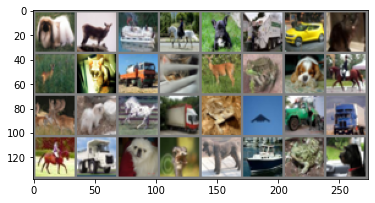

In [ ]:
def imshow(img):
    img = img *(0.5) + 0.5     # unnormalize x' = (x-miu)/sigma -> x = sigma * x'+ miu
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # from cwh to whc layout

# get some random training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() this pops a error, because python version , use the next line and this is fixed 
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print image shape
print(images.shape)
CHANNELS, HEIGHT, WIDTH = images.shape[1:]



##First approch: flatten images to a vector and feeds it into a FCN

In [ ]:

# images.flatten(start_dim=2).shape :torch.Size([32, 3, 1024]) 
images.flatten(start_dim=1).shape # :torch.Size([32, 3072])

torch.Size([32, 3072])

In [ ]:
class MLP(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x

In [ ]:
def initialize_baseline_model(feature_count, hidden_layer_size, class_count):
  baseline_model = MLP(feature_count, hidden_layer_size, class_count)
  baseline_model = baseline_model.to(device)
  return baseline_model

feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)

###Testing Model

In [ ]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

logits = baseline_model.forward(images.flatten(start_dim=1).to(device))

print('Logits shape:',logits.shape)

Logits shape: torch.Size([32, 10])


###Loss Function &
###Optimizers

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), learning_rate)

## **Validation** 

During the training, we optimize the cross-entropy loss. Most of the times, we are rather interested in a different metric such as accuracy or recall in order to measure the performance of the model. This can be done during the validation. Validation can be either computed on the training or on the validation dataset (which is more common). By computing the accuracy on the validation set we get a first impression how the model performs on unseen data.

We need now to define a validation method for our model. A method to measure the accuracy on the validation set.

This function takes:

1. Trained model
2.Test dataloader

and returns:



* Test accuracy





In [ ]:
def validate_model(model: torch.nn.Module, data, flatten_flag=True):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        for batch, labels in data:
            labels = labels.to(device)
            
            if flatten_flag:
              predictions = model(batch.to(device).flatten(start_dim=1))
            else:
              predictions = model(batch.to(device))

            predictions = predictions.argmax(dim=1)  # 区别max 与argmax：argmax 取index
            top_1 = predictions==labels
            top_1 = top_1.type(torch.float)
            top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

# OR just take a single (batch,labels) pair and return accuracy. This will be usefull next for training loop.

def validate_single_batch(model: torch.nn.Module, batch, labels):
    model.eval()
    with torch.no_grad():
        top_1_accuracy = []
        predictions = model(batch)
        predictions = predictions.argmax(dim=1)
        top_1 = predictions==labels
        top_1 = top_1.type(torch.float)
        top_1_accuracy.append(top_1.mean().cpu())
    return np.mean(top_1_accuracy)

Visulization of the output distribution of the network depended on the input

In [ ]:
def show_output_distributions(model, data, flatten=True):
    rows, cols = 2,5
    device = next(model.parameters()).device
    with torch.no_grad():
        fig = plt.figure(figsize=(20,5))
        for i in range(1, rows*cols+1):
            image, label = data[i-1]
            image = image.unsqueeze(0)
            image = image.to(device)
            if flatten:
                image = image.flatten(start_dim=1)
            prediction = model(image)
            ax = fig.add_subplot(rows,cols,i)
            ax.bar(range(10),prediction.detach().squeeze().cpu().numpy())
            ax.set_title(f"Label: {label}")
            ax.set_xlabel("Predicted Labels")
    plt.subplots_adjust(hspace=0.5)
    plt.show()

Let's experiment our untrained model and understand what the output of the default model looks like.

Why do you think the accuracy is always around 0.1 for untrained model?

In [ ]:
validation_score = validate_model(baseline_model, test_loader)
print(f"The untrained model has a validation score of {validation_score}")

The untrained model has a validation score of 0.13268770277500153


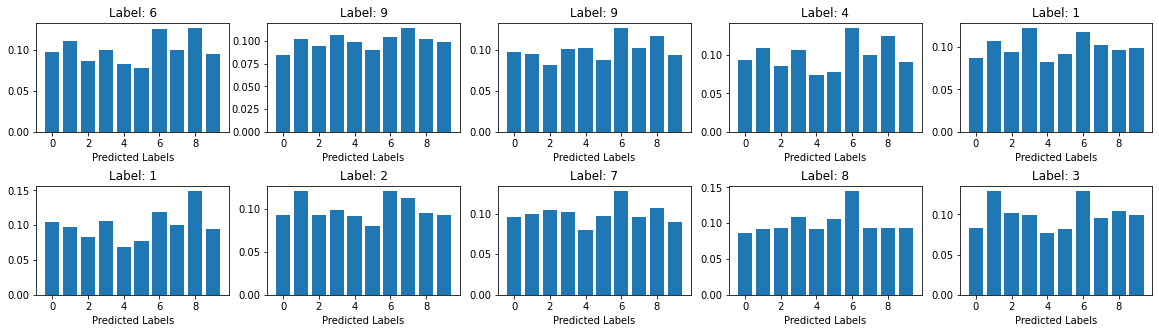

In [ ]:
show_output_distributions(baseline_model, train_dataset)

## **Training** 

We need now to combine everything in a single training loop. Training loop will update my model weights to enhance its accuracy.

This loop should take as an argument:

Epochs count
Model
Train Dataloader
Optimizer
Loss Function
and should return:

Trained model
Epoch logs (training loss, training accuracy, ##weight histograms)

In [ ]:
def train_model(epochs, model, dataloader_train, dataloader_val, optimizer, loss_function, writer, flatten_flag=True, val_step=2, identifier=None):
  
  # this blcok under can not be used for Generalization of other deep learning project so it is commented out by me
  # (if choose not to train, this will return the well trained model from its log of the package)
  # if not TRAIN_IN_NOTEBOOK:  
  #   assert identifier is not None, "Need to pass identifier to load correct model"
  #   model = torch.load(path.join("lecture_models", identifier, identifier + "_model.pt"), map_location=device)
  #   return model, None, None

  # To log the loss
  epoch_loss =[]
  epoch_acc =[]
  for epoch in range(epochs):
    #model.train()
    cur_loss = []
    cur_acc = []

    for batch_idx, (batch, labels) in enumerate(dataloader_train):

      if flatten_flag:
              batch, labels = batch.to(device).flatten(start_dim=1), labels.to(device) # flatten：输入是否向量化
      else:
              batch, labels = batch.to(device), labels.to(device)

      #Reset the optimizer 
      optimizer.zero_grad()
      prediction = model(batch)
      loss = loss_function(prediction,labels)
      #Backpropagate the error
      loss.backward()
      #Update the Weights based on the error
      optimizer.step()

      cur_acc.append(validate_single_batch(model,batch,labels))
      cur_loss.append(loss.item())

    # Validate the model every n-th episode
    if epoch % val_step ==0:
      val_score= validate_model(model,dataloader_val, flatten_flag)
      print(f"Validation score after epoch {epoch}:{val_score:.3f}")
      writer.add_scalar("Acc/val", val_score, epoch//val_step)  #  what does this line do ? 
    epoch_loss.append(np.mean(cur_loss))
    epoch_acc.append(np.mean(cur_acc))

    for name, layer in model.named_children():  # how exactly does this part work ?
        if hasattr(layer, "weight"):
            writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
            writer.add_histogram(f"Histogram/{name}", layer.weight, epoch)
    writer.add_scalar("Loss/train", epoch_loss[-1], epoch)
    writer.add_scalar("Acc/train", epoch_acc[-1], epoch)

    print(f"Finished epoch {epoch+1}: Loss= {epoch_loss[-1]}, Accuracy= {epoch_acc[-1]}")

  return model, epoch_loss, epoch_acc

  
    



## **Training Experiments** 

There are multiple approaches on how to improve the model performance, these can roughly be categorized into 2 categories:
- Improve the training procedure
    - Change/adapt the optimizer (Learning rate, momentum, different optimizer, regularization)
    - Data related changes (data augmentation to benefit more from existing data, change batchsize)
- Improve the model architecture / model related changes
    - Change width/depth of the model
    - Use a different type of model (CNN instead of MLP)
    - Include skip connections

This list is not extensive and there are no boundaries to your imagination on what to change. The presented experiments are only examples and there might very well be a setting which outperforms the currently presented examples. You might want to try SGD with momentum or the Adam optimizer for instance. Feel free to run your own experiments.

We define the number of epochs for how long the model should be trained. Depended on your GPU/CPU it can take quite long to train a single epoch.

#### **Baseline** 
Train the baseline model. Each experiment has a unique identifier under which we safe it's logs and the final model.

In [ ]:
identifier = 'Baseline_SGD_lr005_CE'
model_path = path.join(path_to_models, identifier) 
mksafe_dir(model_path)  # 运行后mymodels 文件夹下会出现一个 名为Baseline_SGD_lr005_CE的子文件夹

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.005
epochs = 30

# initialize model & Train
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")

### **added by me ** plot loss(epoch) accuracy(epoch)

In [ ]:


# Print Result

#fig,ax = plt.subplots() #创建图实例
fig,ax = plt.subplots()
#x = epoch_list
epoch_list = np.arange(30)
ax.plot(epoch_list,exp_loss,label='Baseline_SGD_lr005_CE')      # 作 loss = f(epoch) 图，并标记此线名为linear
# ax.plot(epoch_list, exp_acc, label='linear')  # 作 accuracy = f(epoch) 图，并标记此线名为linear
ax.set_ylabel('loss')

ax.set_xlabel("epoch")
ax.legend() #自动检测要在图例中显示的元素，并且显示
plt.show()

# find the epoch which has the min / max of the exp_loss / exp_acur
# given that they are list []

import operator
index, value = min(enumerate(exp_loss), key=operator.itemgetter(1))



# w =[]
# for epoch in range(10):
#   w.append(epoch)
# w



2.0208577615514596



```
# 此内容为代码格式
```



take a look what tranning does to model

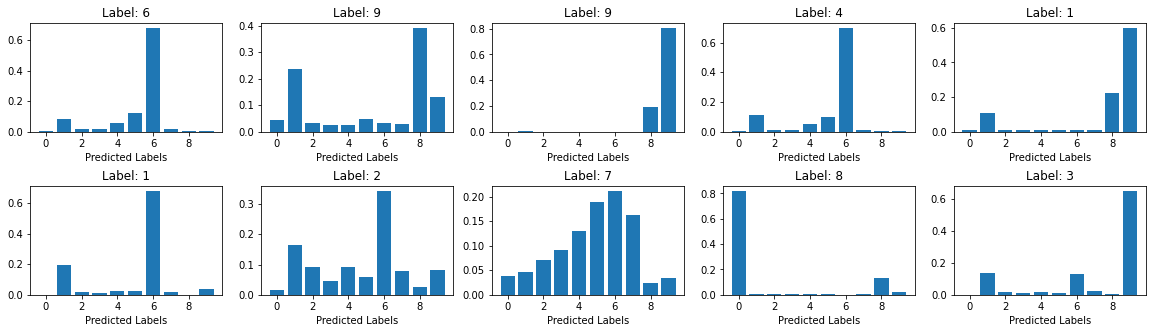

In [ ]:
show_output_distributions(baseline_model, train_dataset)

### **Improve the training procedure**
#### **Changes in learning rate** 


##### **Decrease the lr (0.0005)** 

In [ ]:
# creatre a folder to save this model's log 
identifier = 'Baseline_SGD_lr0005_CE'
model_path = path.join(path_to_models, identifier) 
mksafe_dir(model_path)  # 运行后mymodels 文件夹下会出现一个 名为Baseline_SGD_lr005_CE的子文件夹

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.0005
epochs = 2

# initialize model
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_0005 = optim.SGD(baseline_model.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")

Validation score after epoch 0:0.113
Finished epoch 1: Loss= 2.3028942452587535, Accuracy= 0.11274392157793045
Finished epoch 2: Loss= 2.3028897987446264, Accuracy= 0.1127639189362526
The Baseline_SGD_lr0005_CE model has a validation score of 0.11271964758634567


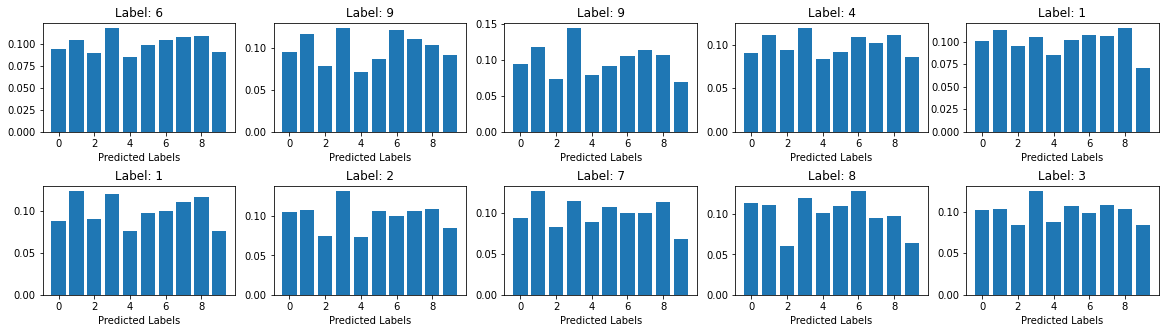

In [ ]:
show_output_distributions(baseline_model, train_dataset)

#### **Changes in Batch Size** 

##### **Reduce Batch Size to 4** 

In [ ]:
# create a new trainloader with batch size sepcified to 4
trainloader_BS4 = torch.utils.data.DataLoader(train_dataset,
                        batch_size=4,
                        shuffle=True,
                        num_workers=2)

# creatre a folder to save this model's log 
identifier = "Baseline_SGD_lr005_CE_BS4"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.005
epochs = 2

# initialize model
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_0005 = optim.SGD(baseline_model.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")

Validation score after epoch 0:0.096
Finished epoch 1: Loss= 2.302160632816249, Accuracy= 0.09293026477098465
Finished epoch 2: Loss= 2.3021639358974464, Accuracy= 0.09289027750492096
The Baseline_SGD_lr005_CE_BS4 model has a validation score of 0.09554712474346161


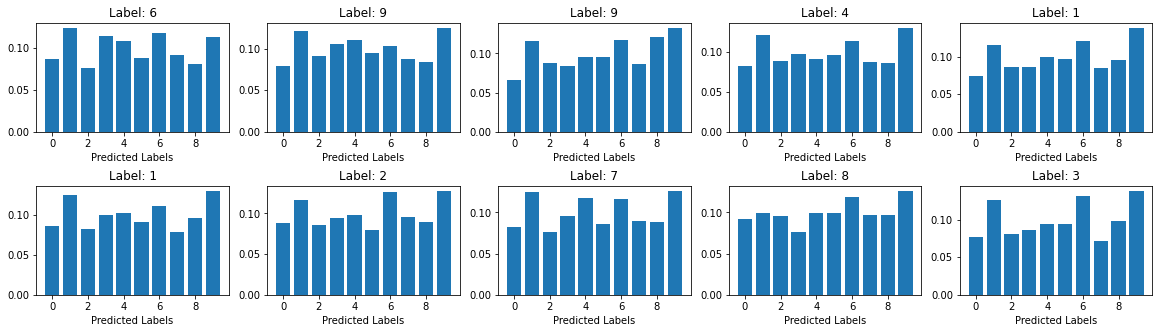

In [ ]:
show_output_distributions(baseline_model, train_dataset)

### **Data Augmentations** 
The basic idea of data augmentation is to present the same image in various shapes, forms and colors. By adding noise, we hope that the networks becomes more robust against noise in unseen images. 

In [ ]:
## Added torchvision.transforms.RandomHorizontalFlip()
# add augmentation into transform pipeline
transform = transforms.Compose(
    [transforms.ToTensor(),
     torchvision.transforms.RandomHorizontalFlip(),  #  this is the change
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

##

train_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root=path_to_data, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# creatre a folder to save this model's log 
identifier = "Baseline_SGD_lr005_CE_Aug"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.005
epochs = 2

# initialize model
baseline_model = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_0005 = optim.SGD(baseline_model.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")

Files already downloaded and verified
Files already downloaded and verified
Validation score after epoch 0:0.087
Finished epoch 1: Loss= 2.3039156885690133, Accuracy= 0.08703214675188065
Finished epoch 2: Loss= 2.3039409592604683, Accuracy= 0.08553262799978256
The Baseline_SGD_lr005_CE_Aug model has a validation score of 0.0868610218167305


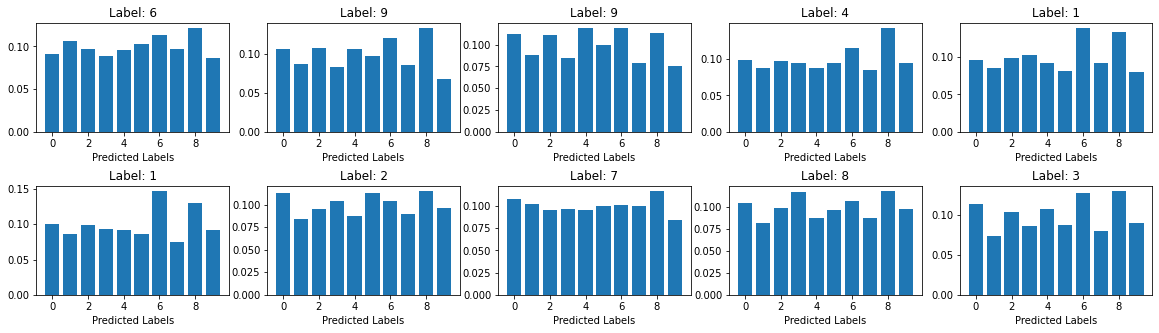

In [ ]:
show_output_distributions(baseline_model, train_dataset)

#### **Dropouts** 
Dropout is a further way to regularize the network.

In [ ]:
class MLP_withdropout(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_withdropout, self).__init__()
        self.hidden_layer = nn.Linear(feature_count, hidden_layer_size)
        self.activation_1 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_2 = nn.Softmax(dim=0)
        self.dropout = nn.Dropout(0.25) # added
    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_layer(x)
        x = self.activation_1(x)
        x = self.dropout(x) # not a good practise to drop out on the first layer
        x = self.output_layer(x)
        x = self.activation_2(x)
        return x

# creatre a folder to save this model's log 
identifier = "Baseline_SGD_lr005_CE_Drop"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.005
epochs = 2

# initialize model
baseline_with_dropouts = initialize_baseline_model(feature_count, hidden_layer_size, class_count)
writer = SummaryWriter(path.join(path_to_logs, identifier))

SGD_optimizer_0005 = optim.SGD(baseline_with_dropouts.parameters(), Learning_rate)
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")


Validation score after epoch 0:0.088
Finished epoch 1: Loss= 2.303926228256616, Accuracy= 0.08501279354095459
Finished epoch 2: Loss= 2.3039369839395536, Accuracy= 0.0853726789355278
The Baseline_SGD_lr005_CE_Drop model has a validation score of 0.08566293865442276


#### **Changes in model size**
Model changes can either be by increasing the width of the layers or by adding more layers. Both approaches increase the complexity of the learner in different ways.
##### **Increase model size by increasing the hidden layer size from 36 to 128**

In [ ]:
identifier = "MLP_wide_SGD_lr005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)

# initialize model with 128 layer
baseline_model = initialize_baseline_model(feature_count, 128, class_count)

SGD_optimizer_005 = optim.SGD(baseline_model.parameters(), 0.005)

nof_params_orig = sum([tensor.numel() for tensor in initialize_baseline_model(feature_count, hidden_layer_size, class_count).parameters()])
nof_params_wide = sum([tensor.numel() for tensor in baseline_model.parameters()])

print(f"The standard model has {nof_params_orig:,} parameters. The wide model has {nof_params_wide:,} parameters")


# traning settings
Learning_rate = 0.005
epochs = 2


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")


The standard model has 110,998 parameters. The wide model has 394,634 parameters
Validation score after epoch 0:0.255
Finished epoch 1: Loss= 2.269097700839003, Accuracy= 0.22204893827438354
Finished epoch 2: Loss= 2.206714196610893, Accuracy= 0.2665347158908844
The MLP_wide_SGD_lr005_CE model has a validation score of 0.29023560881614685


##### **Increase model size by increasing the number of layers**
Include one more hidden layer.

In [ ]:
class MLP_2layer(nn.Module):
    def __init__(self, feature_count, hidden_layer_size, class_count):
        super(MLP_2layer, self).__init__()
        intermediate_size =  (feature_count + hidden_layer_size)//2
        
        self.hidden_lay_1 = nn.Linear(feature_count, intermediate_size)
        self.activation_1 = nn.ReLU()
        self.hidden_lay_2 = nn.Linear(intermediate_size, hidden_layer_size)
        self.activation_2 = nn.ReLU()
        self.output_layer = nn.Linear(hidden_layer_size, class_count)
        self.activation_3 = nn.Softmax(dim=0)

    def forward(self, x):
        x = x.view(-1, feature_count)
        x = self.hidden_lay_1(x)
        x = self.activation_1(x)
        x = self.hidden_lay_2(x)
        x = self.activation_2(x)
        x = self.output_layer(x)
        x = self.activation_3(x)
        return x

In [ ]:
# creatre a folder to save this model's log 
identifier = 'MLP_deep_SGD_lr005_CE'
model_path = path.join(path_to_models, identifier) 
mksafe_dir(model_path)  # 运行后mymodels 文件夹下会出现一个 名为Baseline_SGD_lr005_CE的子文件夹

# model settings
feature_count = CHANNELS*WIDTH*HEIGHT
hidden_layer_size = 36
class_count = 10

# traning settings
Learning_rate = 0.0005
epochs = 2

# initialize model
deep_model = MLP_2layer(feature_count, hidden_layer_size, class_count).to(device)
SGD_optimizer_005 = optim.SGD(deep_model.parameters(), Learning_rate)

nof_params_orig = sum([tensor.numel() for tensor in initialize_baseline_model(feature_count, hidden_layer_size, class_count).parameters()])
nof_params_deep = sum([tensor.numel() for tensor in deep_model.parameters()])
print(f"The standard model has {nof_params_orig:,} parameters. The deep model has {nof_params_deep:,} parameters")


writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, baseline_model, train_loader, test_loader, SGD_optimizer_005, criterion, writer, identifier=identifier)

#if TRAIN_IN_NOTEBOOK: （we don't use this token，since we want to make a more general pattern for further dl project）
writer.flush() #Python file method flush() flushes the internal buffer,why used here I dunno
torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader)
print(f"The {identifier} model has a validation score of {validation_score}")

The standard model has 110,998 parameters. The deep model has 4,831,792 parameters
Validation score after epoch 0:0.289
Finished epoch 1: Loss= 2.18690688825157, Accuracy= 0.2849288284778595
Finished epoch 2: Loss= 2.1869069957916203, Accuracy= 0.2847088873386383
The MLP_deep_SGD_lr005_CE model has a validation score of 0.2882388234138489


##### **Change the model architecture from MLP to CNN** 
CNNs were designed to make use of the given spatial structure of the image. This already given structure is lost in the MLP by flattening the image. 

In [ ]:
class CNN_Net(nn.Module):
    # at least the following Member methods have to be implemented.   
    def __init__(self,input_channel,class_count):                             # constructor
      super().__init__()
      self.conv1 = torch.nn.Conv2d(input_channel,10,kernel_size = 5)
      self.conv2 = torch.nn.Conv2d(10,20,kernel_size = 5)
      self.pooling = torch.nn.MaxPool2d(2)
      self.fc = torch.nn.Linear(500, class_count) #

      self.activate_1 = torch.nn.ReLU()
      self.activate_2 = torch.nn.Softmax(dim=1)  # CrossEntropyLoss 不是不用加softmx层的吗？ PPT上是不加的，但是不加的话后面的分布很奇怪有复数的，所以
                              # 现在加上去看看是不是这边问题, 好像不是加上去反而更奇怪了

    def forward(self,x):  
      batch_size = x.size(0)       
      x = self.conv1(x)          #which means we must realign each input to vector-like tensor
      x = self.pooling(x)
      x = self.activate_1(x)        
      x = self.conv2(x)         # 业界惯例全用形参x 防止出错，
      x = self.pooling(x)
      x = self.activate_1(x) 
      x = x.view(batch_size,-1)   # batch_size 从哪里传来？batch_size = 64   # code 开头的全局定义  (Rearrange x to batch_size行， 缺省列)
      x = self.fc(x) 
      x = self.activate_2(x)                     
      return x

    # def __init__(self):
    #     super().__init__()
    #     self.conv1 = nn.Conv2d(3, 6, 5)
    #     self.pool = nn.MaxPool2d(2, 2)
    #     self.conv2 = nn.Conv2d(6, 16, 5)
    #     self.fc1 = nn.Linear(16 * 5 * 5, 120)
    #     self.fc2 = nn.Linear(120, 84)
    #     self.fc3 = nn.Linear(84, 10)

    # def forward(self, x):
    #     x = self.pool(F.relu(self.conv1(x)))
    #     x = self.pool(F.relu(self.conv2(x)))
    #     x = torch.flatten(x, 1) # flatten all dimensions except batch
    #     x = F.relu(self.fc1(x))
    #     x = F.relu(self.fc2(x))
    #     x = self.fc3(x)
    #     x = F.softmax(x,dim=1)
    #     return x

In [ ]:
# create log
identifier = "CNN_SGD_lr005_CE"
model_path = path.join(path_to_models, identifier)
mksafe_dir(model_path)


# Traning settings
Learning_rate = 0.005
epochs = 20
CNN_MODEL = CNN_Net(input_channel=3,class_count=10).to(device)
SGD_optimizer_005_momentum = optim.SGD(CNN_MODEL.parameters(), Learning_rate,momentum=0.3)

writer = SummaryWriter(path.join(path_to_logs, identifier))
exp_model, exp_loss, exp_acc = train_model(epochs, CNN_MODEL, train_loader, test_loader, SGD_optimizer_005_momentum, criterion, writer, flatten_flag=False, identifier=identifier)



if TRAIN_IN_NOTEBOOK:
    writer.flush()
    torch.save(exp_model, path.join(model_path, identifier + "_model.pt"))

validation_score = validate_model(exp_model, test_loader, flatten_flag=False)
print(f"The {identifier} model has a validation score of {validation_score}")

Validation score after epoch 0:0.100
Finished epoch 1: Loss= 2.2999421685304844, Accuracy= 0.10346689075231552
Finished epoch 2: Loss= 2.2845775023989394, Accuracy= 0.11456333845853806
Validation score after epoch 2:0.301
Finished epoch 3: Loss= 2.2033331549785418, Accuracy= 0.2685340642929077
Finished epoch 4: Loss= 2.1434916906912056, Accuracy= 0.32635557651519775
Validation score after epoch 4:0.365
Finished epoch 5: Loss= 2.116995974526677, Accuracy= 0.35756558179855347
Finished epoch 6: Loss= 2.0995775827290686, Accuracy= 0.378418892621994
Validation score after epoch 6:0.385
Finished epoch 7: Loss= 2.085728053778162, Accuracy= 0.3937940001487732
Finished epoch 8: Loss= 2.0715753531806835, Accuracy= 0.408149391412735
Validation score after epoch 8:0.409
Finished epoch 9: Loss= 2.0576771900429605, Accuracy= 0.4254038631916046
Finished epoch 10: Loss= 2.0454948940722515, Accuracy= 0.43668025732040405
Validation score after epoch 10:0.434
Finished epoch 11: Loss= 2.0348862139597506, 

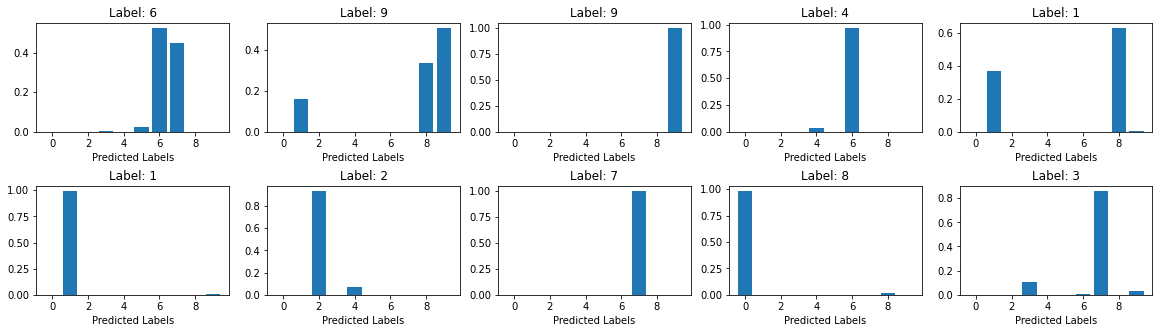

In [ ]:
show_output_distributions(CNN_MODEL, train_dataset, flatten=False)

## Play around with the trained model (doing some prediction)

tensor([6, 9, 5, 6, 5, 5, 9, 2, 2, 2, 0, 5, 5, 7, 5, 5, 8, 7, 4, 9, 2, 0, 9, 5,
        9, 0, 2, 7, 9, 6, 2, 4])
torch.Size([32, 10])
[3 9 1 6 2 5 9 4 9 4 0 7 3 7 3 5 2 6 3 1 1 0 9 6 9 0 8 4 9 1 0 4]
['cat', 'truck', 'car', 'frog', 'bird', 'dog', 'truck', 'deer', 'truck', 'deer', 'Plane', 'horse', 'cat', 'horse', 'cat', 'dog', 'bird', 'frog', 'cat', 'car', 'car', 'Plane', 'truck', 'frog', 'truck', 'Plane', 'ship', 'deer', 'truck', 'car', 'Plane', 'deer']
['frog', 'truck', 'dog', 'frog', 'dog', 'dog', 'truck', 'bird', 'bird', 'bird', 'Plane', 'dog', 'dog', 'horse', 'dog', 'dog', 'ship', 'horse', 'deer', 'truck', 'bird', 'Plane', 'truck', 'dog', 'truck', 'Plane', 'bird', 'horse', 'truck', 'frog', 'bird', 'deer']


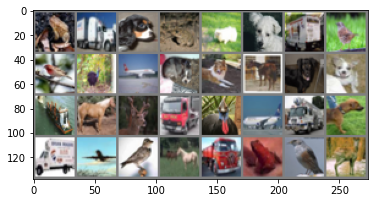

In [ ]:
# get some random training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() this pops a error, because python version , use the next line and this is fixed 
images, labels = next(dataiter)
images.to(device)
# show images
imshow(torchvision.utils.make_grid(images))
print(labels)

# used the trained model to predict the labels of the given batch
predictions = CNN_MODEL.forward(images.to(device))
print(predictions.shape)

# get the most possible index in each item of that batch
predictions = predictions.argmax(dim=1)  # 区别max 与argmax：argmax 取index
label_pred = torch.squeeze(predictions)

# convert tensor to array
np_arr = label_pred.cpu().detach().numpy() 
print(np_arr)
# # convert label tensor to array
la_arr = labels.cpu().detach().numpy() 

# create a dictionary
thisdict = {  
  0: "Plane",
  1: "car",
  2: "bird",
  3: "cat",
  4: "deer",
  5: "dog",
  6: "frog",
  7: "horse",
  8: "ship",
  9: "truck",
}
# mapping labels to catagories

# there must be a more sufficent way but I forgot 
d = []
for item in np_arr :
  d.append(thisdict[item])

print(d)
b =[]
for item in la_arr :
  b.append(thisdict[item])
print(b)




In [ ]:

thisdict = {
  1: "Ford",
  2: "Mustang",
  3: "1964"
}
arr = [2,3,1]
d = []
for item in arr :
  d.append(thisdict[item])
d

['Mustang', '1964', 'Ford']

####
**下面是之前我自己用的 CNNNET model 的定义**

```
{
# at least the following Member methods have to be implemented.   
  def __init__(self,input_channel,class_count):                             # constructor
    super(CNNNet,self).__init__()
    self.conv1 = torch.nn.Conv2d(input_channel,10,kernel_size = 5)
    self.conv2 = torch.nn.Conv2d(10,20,kernel_size = 5)
    self.pooling = torch.nn.MaxPool2d(2)
    self.fc = torch.nn.Linear(500, class_count) #
  
    self.activate_1 = torch.nn.ReLU()
    #self.activate_2 = torch.nn.Softmax(dim=1)  # CrossEntropyLoss 不是不用加softmx层的吗？ PPT上是不加的，但是不加的话后面的分布很奇怪有复数的，所以
                            # 现在加上去看看是不是这边问题, 好像不是加上去反而更奇怪了
    
  def forward(self,x):  
    batch_size = x.size(0)       
    x = self.conv1(x)          #which means we must realign each input to vector-like tensor
    x = self.pooling(x)
    x = self.activate_1(x)        
    x = self.conv2(x)         # 业界惯例全用形参x 防止出错，
    x = self.pooling(x)
    x = self.activate_1(x) 
    x = x.view(batch_size,-1)   # batch_size 从哪里传来？batch_size = 64   # code 开头的全局定义  (Rearrange x to batch_size行， 缺省列)
    x = self.fc(x) 
    #x = self.activate_2(x)                     
    return x
}
```



In [ ]:
# 2. Design Model using Class

class CNNNet (torch.nn.Module): 

  def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

  def forward(self, x):
      x = self.pool(F.relu(self.conv1(x)))
      x = self.pool(F.relu(self.conv2(x)))
      x = torch.flatten(x, 1) # flatten all dimensions except batch
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      #x = F.softmax(x,dim=1)  using CrossEntropyLoss so no need to add softmx here
      return x


model = CNNNet()
model = model.to(device)

Initialize Model with settings

In [ ]:
# define a function for initialization wtih settings
def initialize_model(input_channel,  class_count):
  model = CNNNet(input_channel, class_count)
  model = model.to(device)
  return model
## 2.2 Instantiate an Model Instance 

input_channel = 3
class_count = 10

#model = initialize_model(input_channel, class_count)

In [ ]:
# 3. Construct Loss and Optimizer 
criterion = torch.nn.CrossEntropyLoss()       #  Here is the seconde difference 
                            # No argument reduction='sum' is needed
                            # when we have reduction='sum' as criterion function's argu, 
                            #the loss & accuracy were very bad!!


optimizer = torch.optim.SGD(model.parameters(),learning_rate,momentum=0.5)  # activate momentum 

In [ ]:
# 4. Trainning Cycle    (we wraped training and testing code blocks into two functions, so code is more tidy)

# 4.1 Define Record holder   
accuracy_list =[]
epoch_list =[]
# Definition of Train

def train(epoch):
  running_loss = 0.0
  for batch_idx,data in enumerate(train_loader,0):   # 0 means ：starts iteration from index 0
    x_data,y_data = data
    x_data,y_data = x_data.to(device), y_data.to(device) # add this line to move data to cuda
    # Forward
    y_pred = model(x_data)
    loss = criterion(y_pred,y_data)
    # Backward & zeroing previous gradient
    optimizer.zero_grad()# before backward, gradient is set to ZERO so it doenst influents next iteration,otherwise it will accumulate
    loss.backward()#bp计算 weights 的gradient
    # Update
    optimizer.step()
    # record loss
    running_loss += loss.item()
    #print outcome after each time 300 iteration has been done
    if batch_idx % 300 == 299:
      print('[%d,%5d]loss:%.3f'%(epoch+1,batch_idx + 1,running_loss/300))
      running_loss = 0.0
  epoch_list.append(epoch)

# Definition of Test

def test():
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images,labels = data
      images, labels = images.to(device), labels.to(device) # add this line
      outputs = model(images)
      _,predicted = torch.max(outputs.data,dim = 1)  # 取得最大值的index放在predicated 中
      total += labels.size(0)   # labels.size = [N,1]
      correct += (predicted ==labels).sum().item()
  print('Accuracy on test set:%d %%' %(100*correct/total))  # 百分比输出格式
  
  accuracy_list.append(correct/total)


#for loop    (we also making so changes to for loop , after that it became to double loop)

for epoch in range(30):    #  Notice this program does not use Mini-Batch for Tranning， we learn it later
  train(epoch)
  test()
  #recored (need adaption, since we r looping on epoch and i , we ll figure it out laterly)
  
  # loss_list_SGD.append(loss.item())
  # epoch_list.append(epoch)

[1,  300]loss:1.144
[1,  600]loss:1.118
[1,  900]loss:1.128
[1, 1200]loss:1.173
[1, 1500]loss:1.175
Accuracy on test set:51 %
[2,  300]loss:1.150
[2,  600]loss:1.130
[2,  900]loss:1.157
[2, 1200]loss:1.175
[2, 1500]loss:1.200
Accuracy on test set:55 %
[3,  300]loss:1.129
[3,  600]loss:1.130
[3,  900]loss:1.188
[3, 1200]loss:1.175
[3, 1500]loss:1.213
Accuracy on test set:54 %
[4,  300]loss:1.106
[4,  600]loss:1.195
[4,  900]loss:1.155
[4, 1200]loss:1.209
[4, 1500]loss:1.207
Accuracy on test set:52 %
[5,  300]loss:1.183
[5,  600]loss:1.174
[5,  900]loss:1.180
[5, 1200]loss:1.217
[5, 1500]loss:1.267
Accuracy on test set:54 %
[6,  300]loss:1.171
[6,  600]loss:1.177
[6,  900]loss:1.206
[6, 1200]loss:1.214
[6, 1500]loss:1.204
Accuracy on test set:48 %
[7,  300]loss:1.156
[7,  600]loss:1.200
[7,  900]loss:1.237
[7, 1200]loss:1.225
[7, 1500]loss:1.209
Accuracy on test set:52 %
[8,  300]loss:1.149
[8,  600]loss:1.187
[8,  900]loss:1.206
[8, 1200]loss:1.252
[8, 1500]loss:1.249
Accuracy on test s

KeyboardInterrupt: ignored

### show model accuracy

### show output distribution

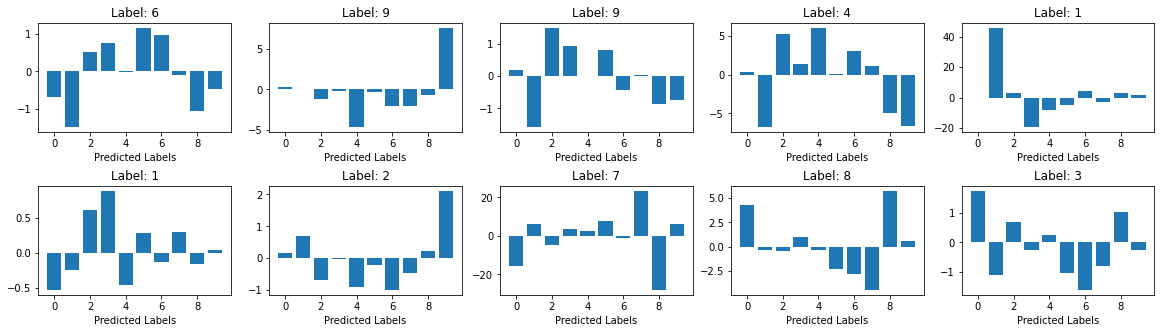

In [ ]:
show_output_distributions(model, train_dataset, flatten=False)

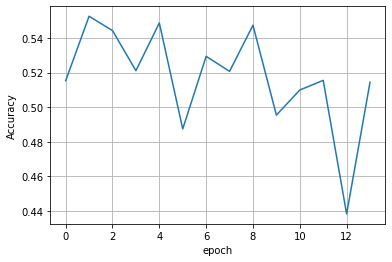

In [ ]:
# print result



plt.plot(epoch_list,accuracy_list)
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.grid()  #  grid actived
plt.show()

encapsulate train block as a function which takes arguments：


1.   epochs
2.   

